# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents')
sys.path.append('../../../RL_lib/Policies/PPO')
sys.path.append('../../../RL_lib/Policies/Common')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Env')
sys.path.append('../../../Imaging')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/Asteroid_CPO_seeker-master/Experiments/Extended/Test_HF


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 1.0000000e+00  0.0000000e+00 -0.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]]
[ 0.0000000e+00 -1.2246468e-16 -1.0000000e+00]
using max  pooling
V4: Output State type:  <function Sensor.optflow_state_range_dp1 at 0x137999488>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x128368748>>
<bound method Sensor.track_func1 of <sensor.Sensor object at 0x128368748>>
6dof dynamics model 
thruster model: 
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Lander Model: 
Reward_terminal equator
queue fixed
Flat Constraint
Attitude Constraint
Rotational Velocity Constraint
Position Hysterises Constraint


<IPython.core.display.Javascript object>


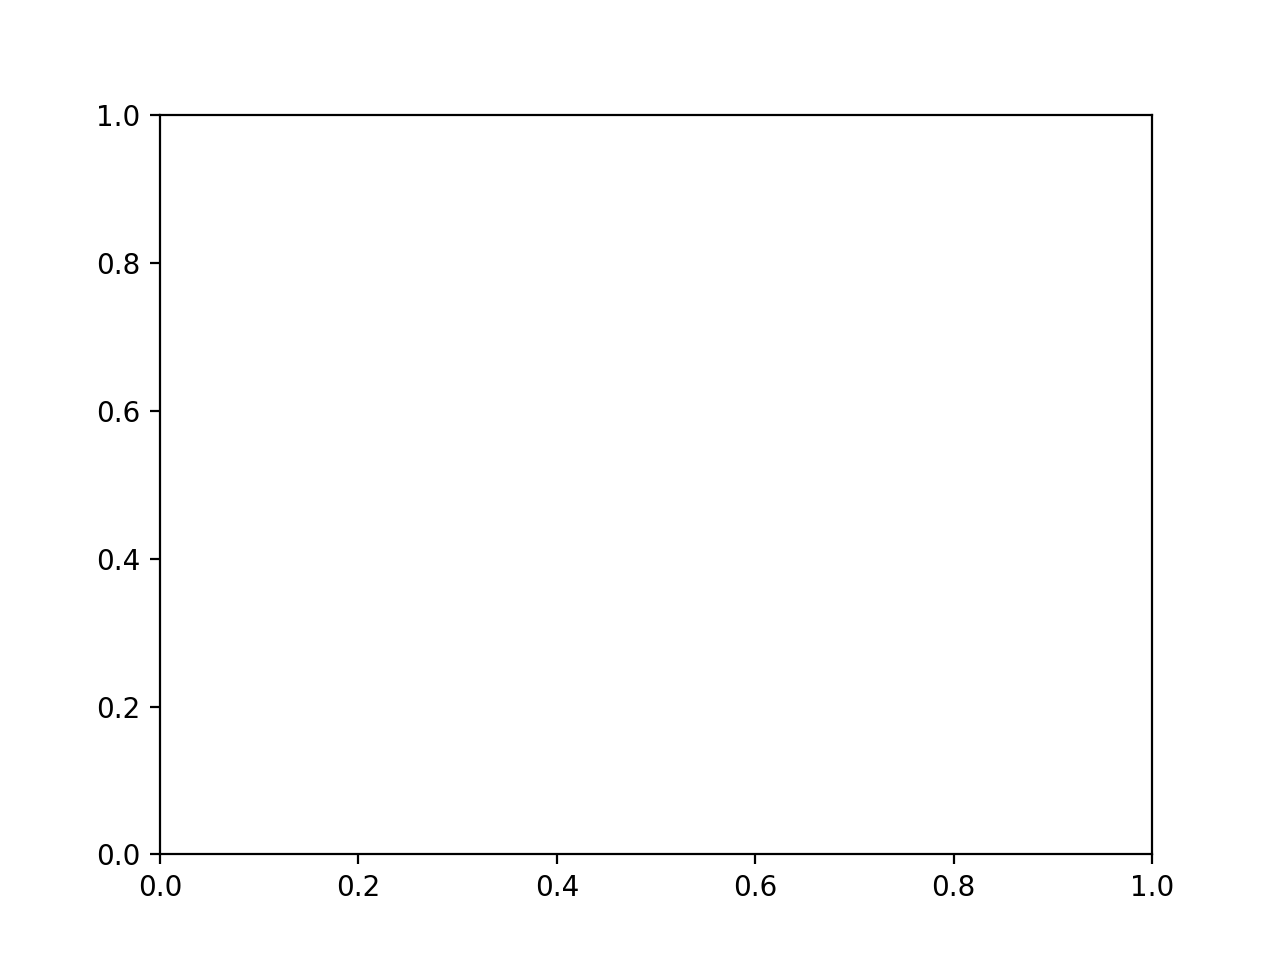

<IPython.core.display.Javascript object>


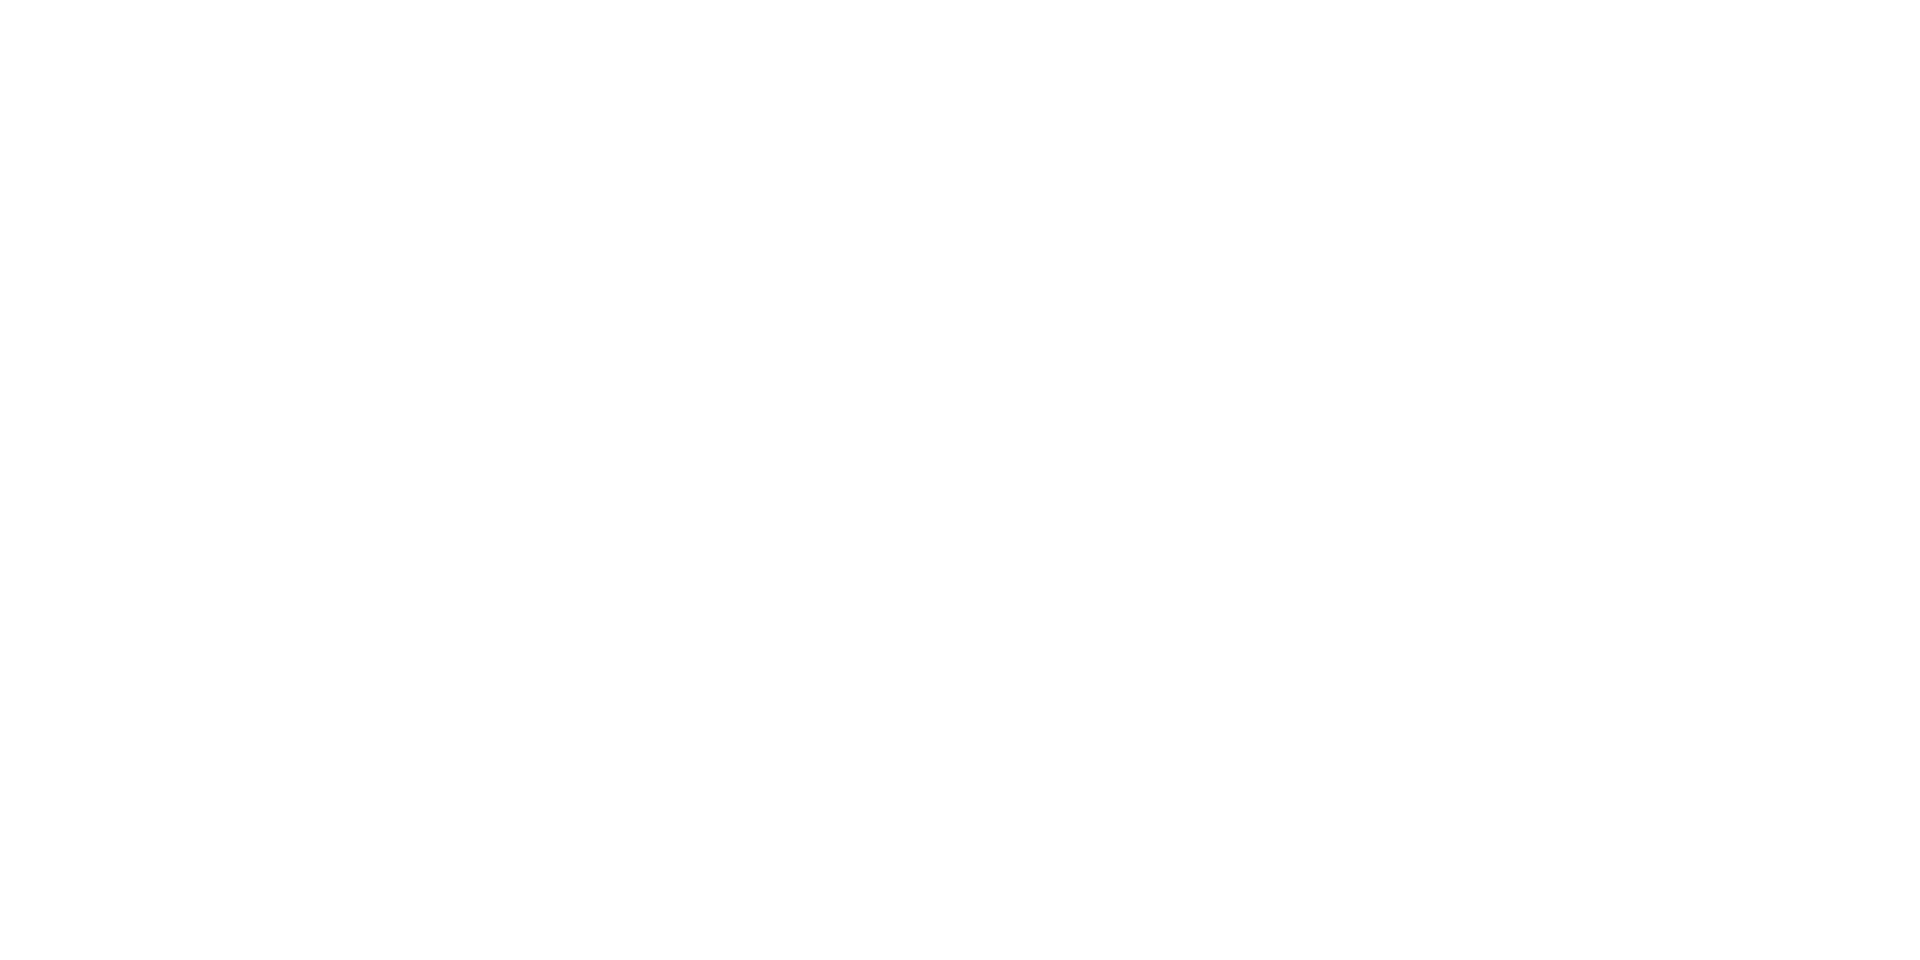

<IPython.core.display.Javascript object>


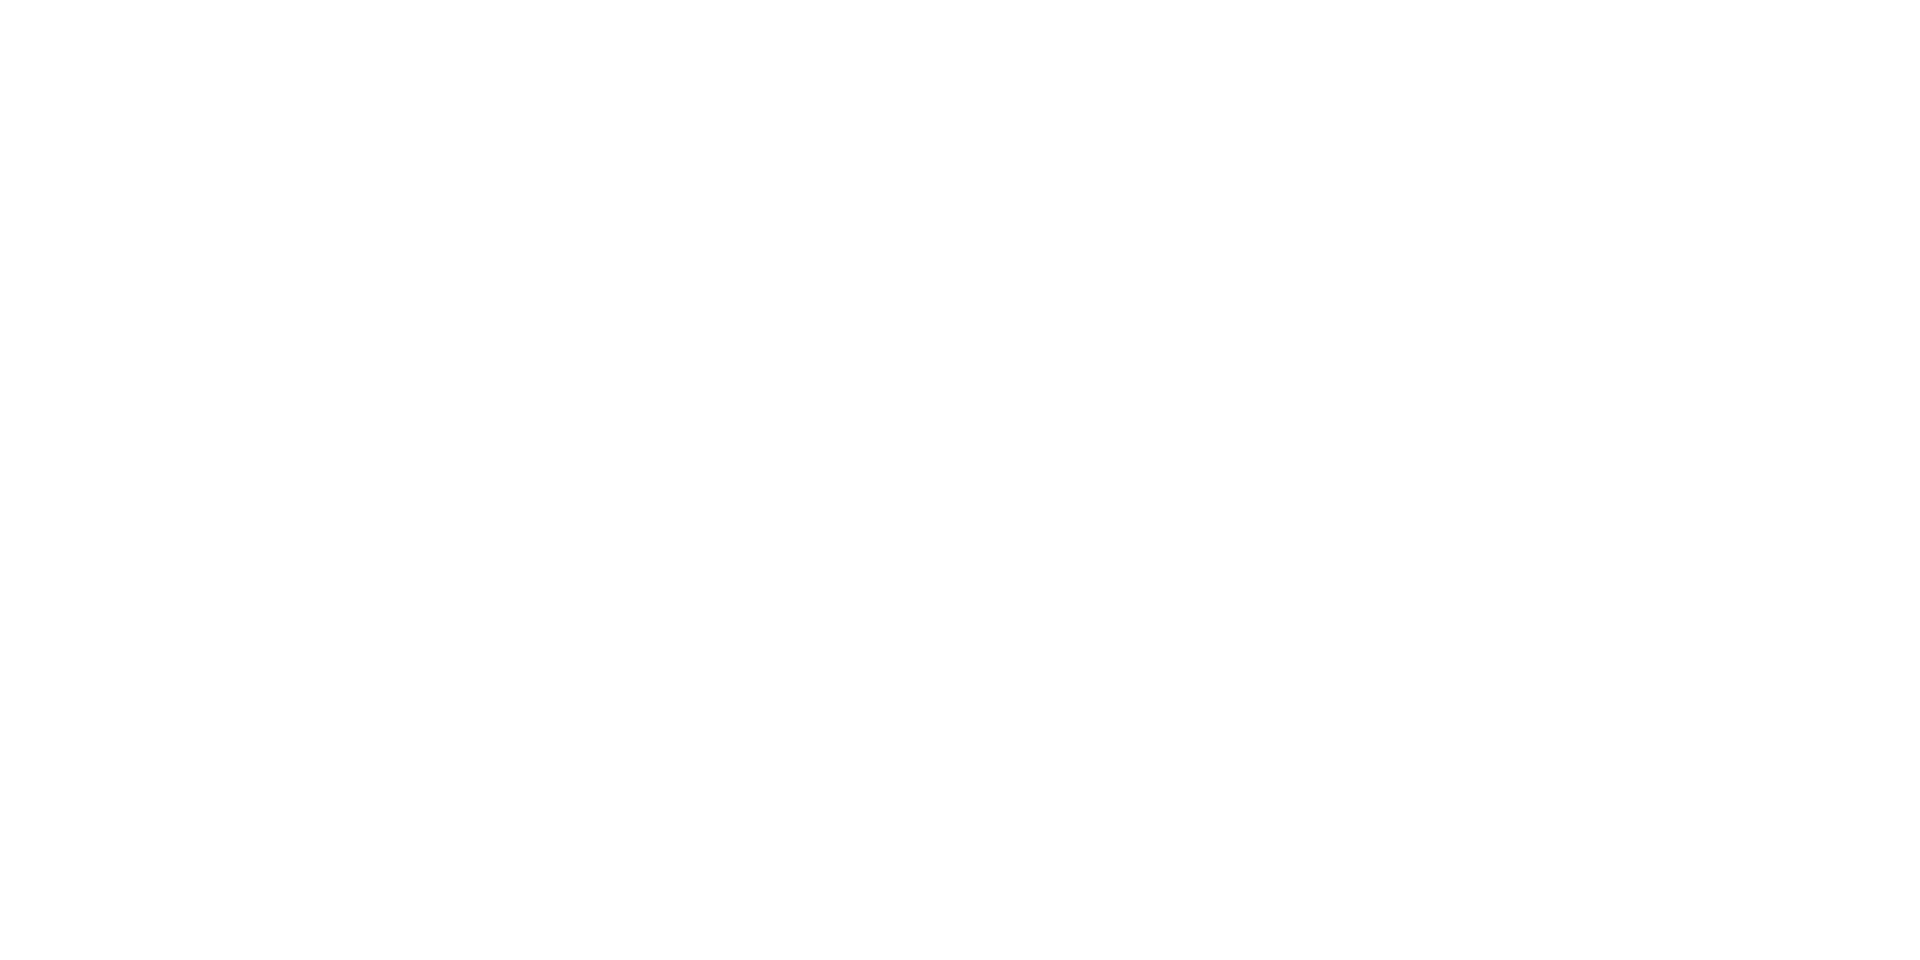

<IPython.core.display.Javascript object>


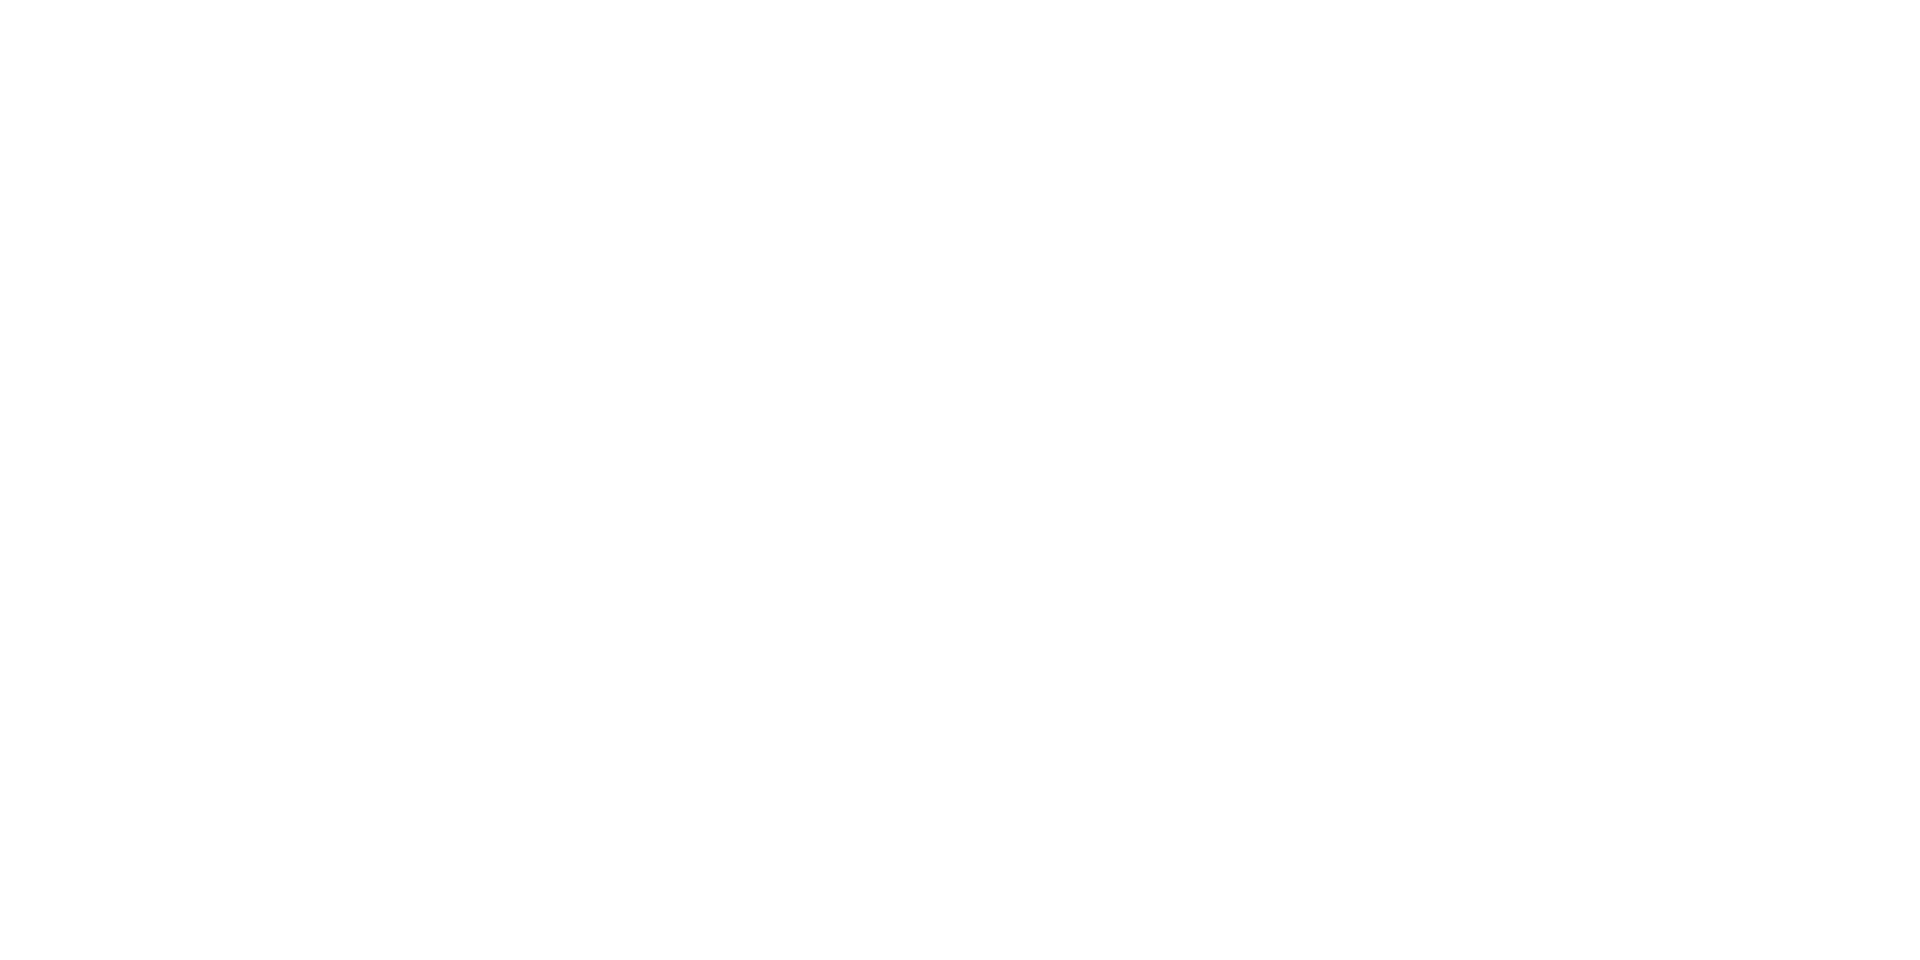

<IPython.core.display.Javascript object>


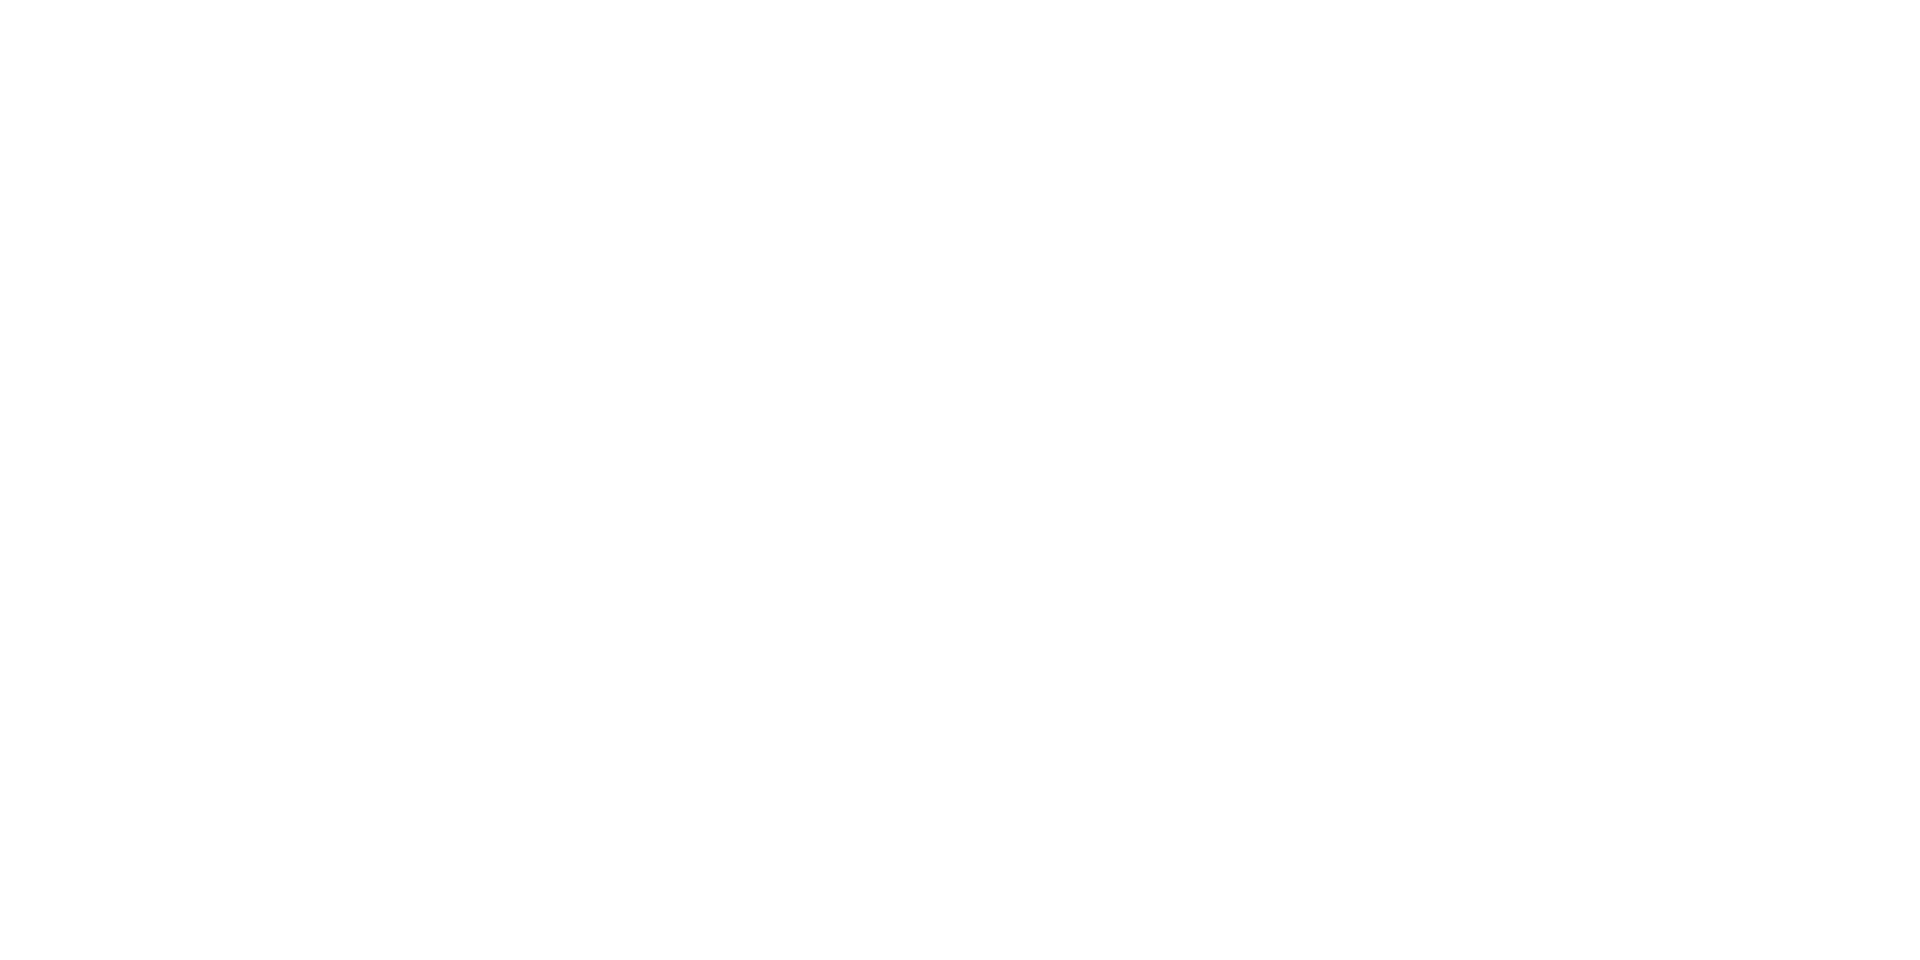

<IPython.core.display.Javascript object>


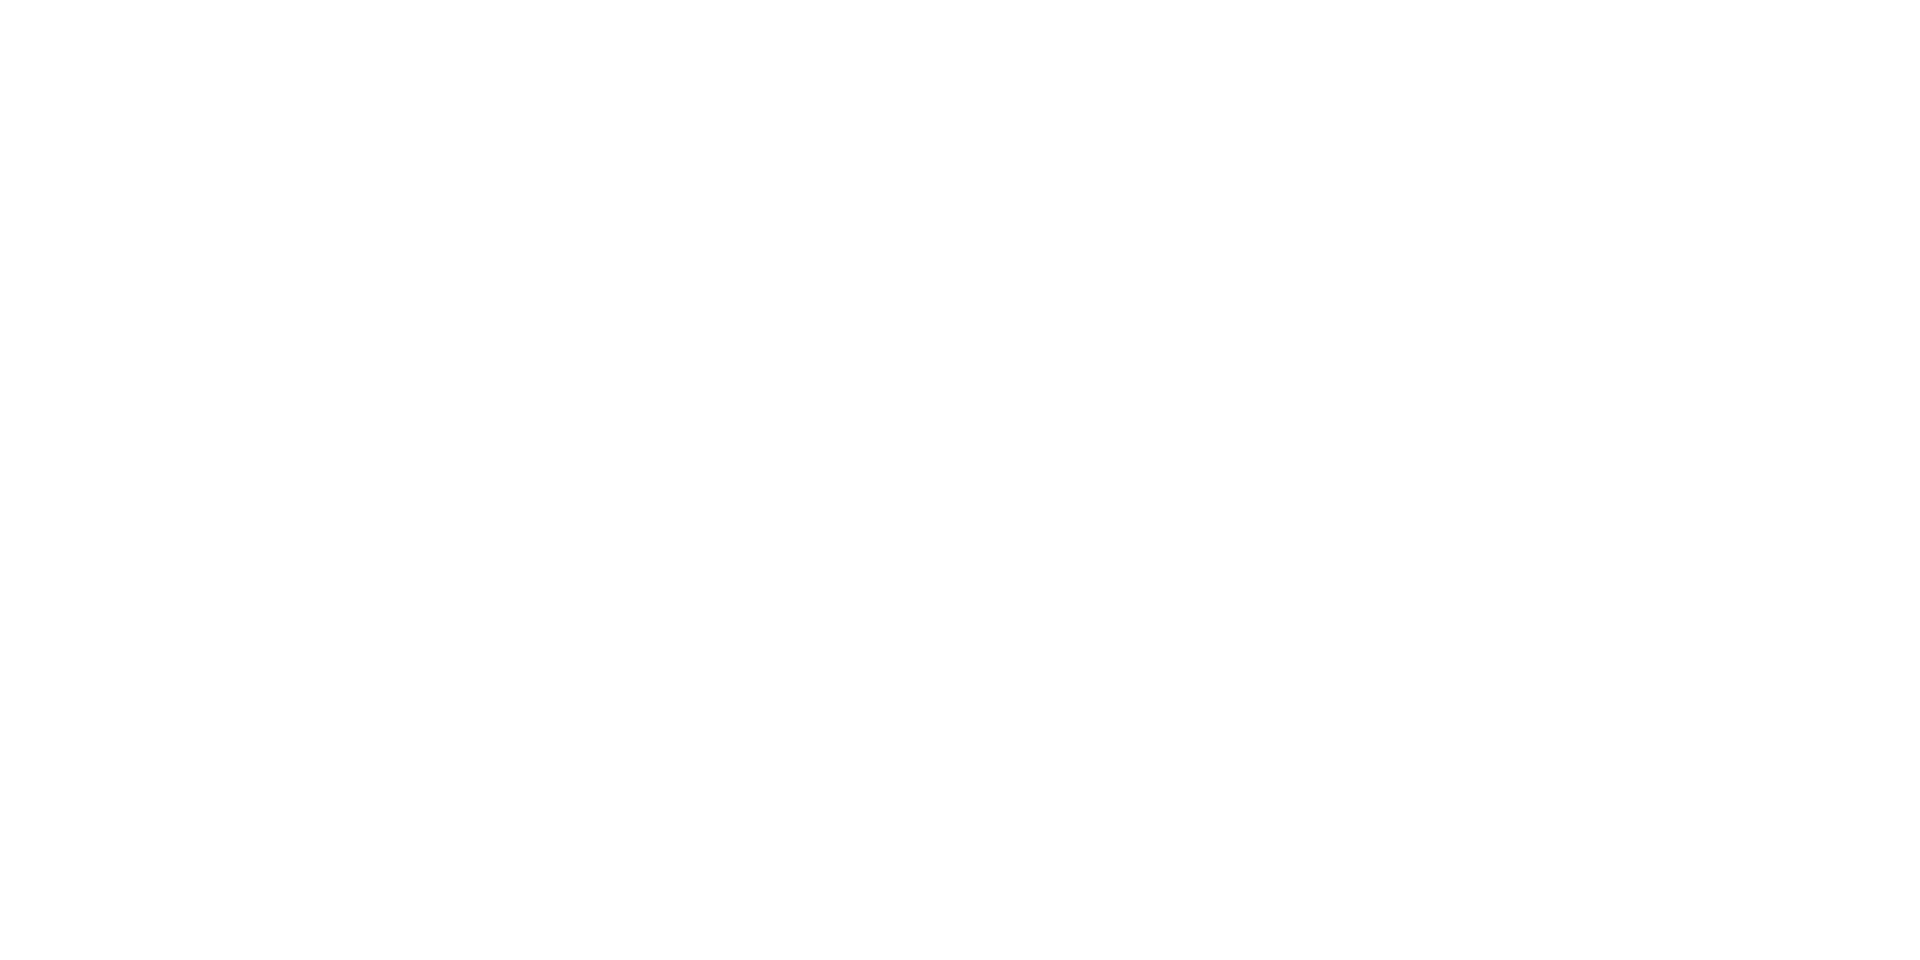

<IPython.core.display.Javascript object>


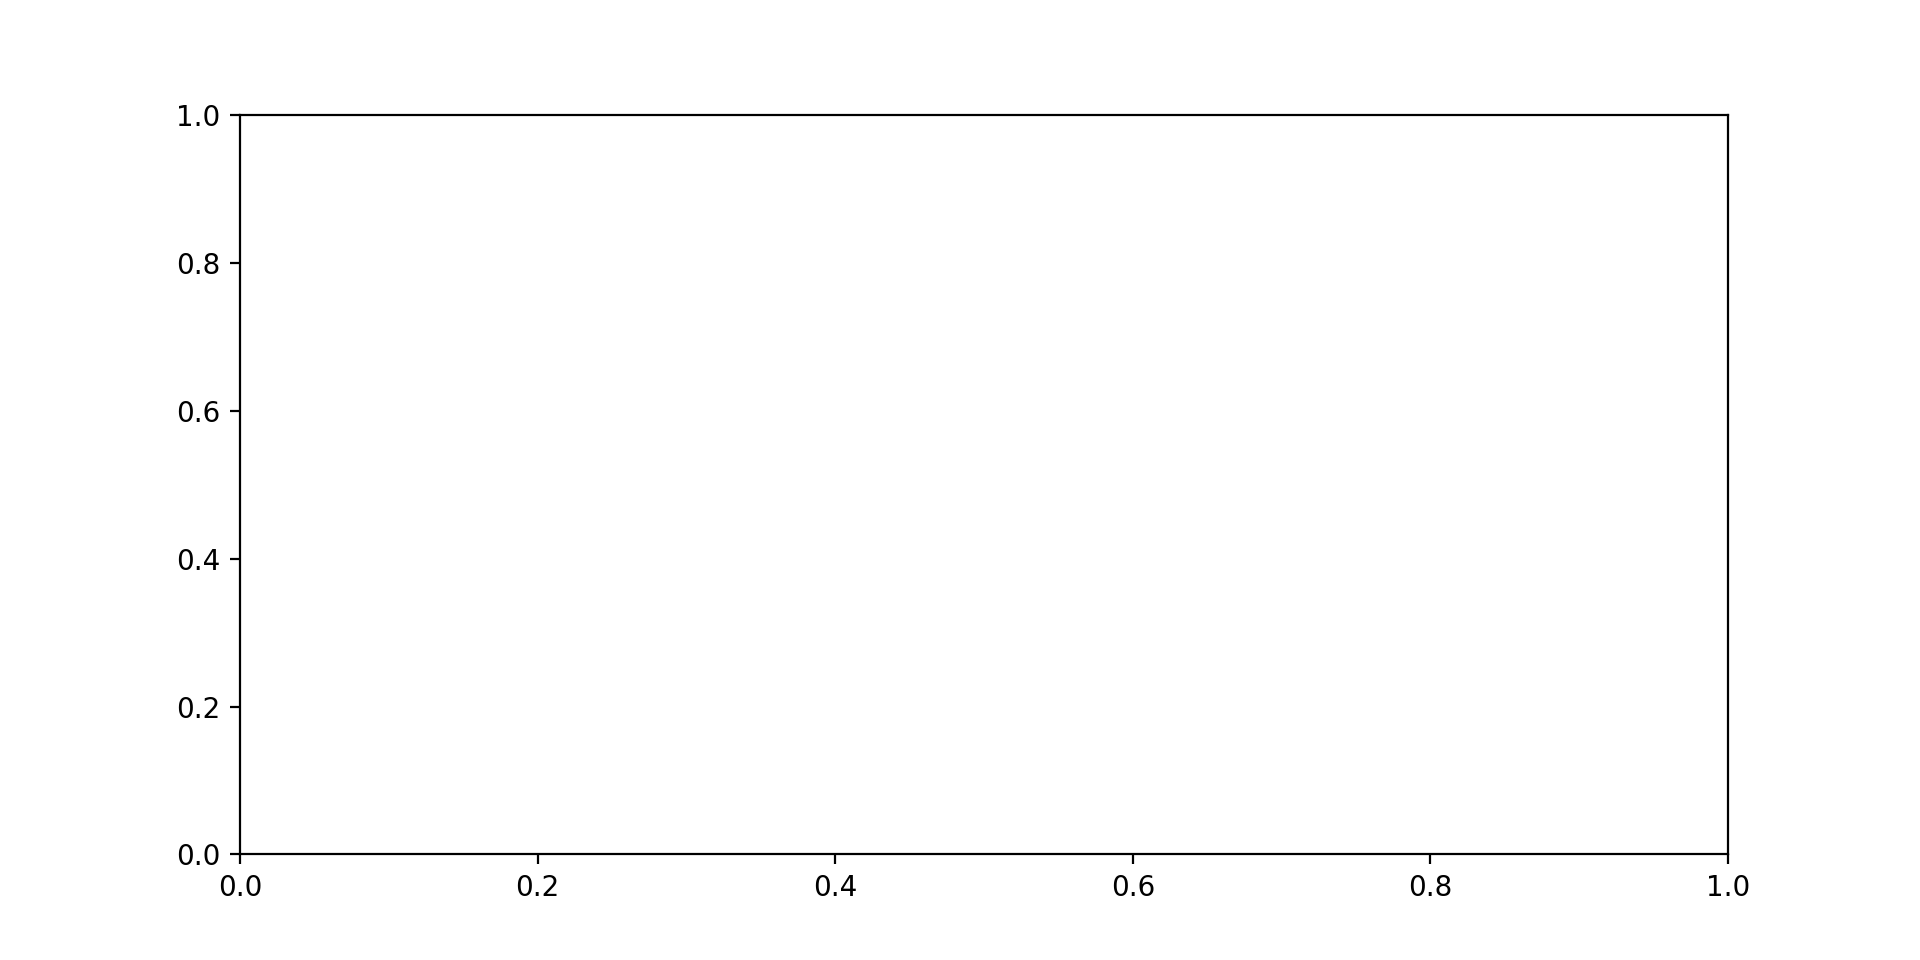

lander env RHL
Landing_icgen:
[[-1.]
 [ 1.]]
Policy with vectorized sample
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 176)
	xn_init: layer  Linear(in_features=176, out_features=240, bias=True)
	xn_init: layer  Linear(in_features=240, out_features=24, bias=True)
Policy: recurrent steps > 1, disabling shuffle
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Shuffle by Chunks:  False
	Max Grad Norm:      30
	Recurrent Steps:    60
	Rollout Limit:      1
	Advantage Func:     <advantage_utils.Adv_default object at 0x139c7d3c8>
	Advantage Norm:     <function Adv_normalizer.apply at 0x136f6f488>
	PD:                 <softmax_pd.Softmax_pd object at 0x139c68ac8>
	Loss Function:      <bound method Policy.calc_loss1 of <policy_ppo.Policy object at 0x139c7d208>>
Value Funtion
	xn_init: layer  Linear(in_features=13, out_features=130, bias=True)
	xn_init: layer  GRUCell(130, 25)
	xn_init: layer  Linear(in_feature

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen import Landing_icgen
import rl_utils
import attitude_utils as attu
import optics_utils as optu
from arch_policy_vf import Arch

from policy_ppo import Policy
from softmax_pd import Softmax_pd as PD
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets


from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from rh_constraint import RH_constraint
from no_attitude_constraint import Attitude_constraint
from w_constraint import W_constraint
from reward_attitude import Reward
from hf_asteroid import Asteroid

from thruster_model_cubesat import Thruster_model

from sensor import Sensor
from seeker import Seeker

landing_site_range = 10.0
landing_site = None #np.asarray([-250.,0.,0.])

asteroid_model = Asteroid(landing_site_override=landing_site, omega_range=(1e-5,5e-4))

ap = attu.Quaternion_attitude()

C_cb = optu.rotate_optical_axis(0.0, 0.0, np.pi)
r_cb = np.asarray([0,0,0])
fov=envu.deg2rad(90)
seeker = Seeker(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb,
                radome_slope_bounds=(-0.05,0.05), range_bias=(-0.05,0.05),
                   fov=fov, debug=False)
sensor = Sensor(seeker, attitude_parameterization=ap,  use_range=True, apf_tau1=300, use_dp=False,
                      landing_site_range=landing_site_range,
                      pool_type='max', state_type=Sensor.optflow_state_range_dp1)
print(sensor.track_func)
sensor.track_func = sensor.track_func1
print(sensor.track_func)
logger = rl_utils.Logger()
dynamics_model = Dynamics_model(h=2)
thruster_model = Thruster_model(pulsed=True, scale=1.0, offset=0.4)
lander_model = Lander_model(asteroid_model, thruster_model, attitude_parameterization=ap, sensor=sensor, 
                             landing_site_range=landing_site_range, com_range=(-0.20,0.20),
                              attitude_bias=0.05, omega_bias=0.05)

lander_model.get_state_agent = lander_model.get_state_agent_sensor_att_w2

obs_dim = 13
action_dim = 12
actions_per_dim = 2
logit_dim = action_dim * actions_per_dim
recurrent_steps = 60

reward_object = Reward(landing_rlimit=2, landing_vlimit=0.1, 
                       tracking_bias=0.01, fov_coeff=-50., 
                       att_coeff=-0.20,
                       tracking_coeff=-0.5, magv_coeff=-1.0,
                       fuel_coeff=-0.10,  landing_coeff=10.0)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
attitude_constraint = Attitude_constraint(ap)
w_constraint = W_constraint(w_limit=(0.1,0.1,0.1), w_margin=(0.05,0.05,0.05))
rh_constraint = RH_constraint(rh_limit=150)

wi=0.05
ic_gen = Landing_icgen((800,1000), 
                           p_engine_fail=0.5,
                           engine_fail_scale=(0.5,1.0),
                           lander_wll=(-wi,-wi,-wi),
                           lander_wul=(wi,wi,wi),
                           attitude_parameterization=ap,
                           position_error=(0,np.pi/4),
                           heading_error=(0,np.pi/8),
                           attitude_error=(0,np.pi/16),
                           min_mass=450, max_mass=500,
                           mag_v=(0.05,0.1),
                           debug=False,
                           inertia_uncertainty_diag=10.0,
                           inertia_uncertainty_offdiag=1.0)

env = Env(ic_gen, lander_model, dynamics_model, logger,
          landing_site_range=landing_site_range,
          debug_done=False,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          attitude_constraint=attitude_constraint,
          w_constraint=w_constraint,
          rh_constraint=rh_constraint,
          tf_limit=5000.0,print_every=10,nav_period=6)




env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
fname = "optimize_WATTVW_FOV-AR=5"
policy.load_params(fname)

# Test Policy 

In [4]:

env.test_policy_batch(agent,5000,print_every=100,keys=lander_model.get_engagement_keys())
#env.test_policy_batch(agent,10,print_every=1)

worked 1
Dynamics: Max Disturbance (m/s^2):  [7.71515630e-06 1.46928582e-05 3.57593650e-06] 1.6976190445981523e-05
i (et): 100  (             452)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.80 |  0.71 |  0.00 |  3.46 |    28
glideslope | 3.137 |12.854 | 0.006 |113.032 |    42
 
Final Stats (mean,std,min,max)
norm_vf  |   0.025 |   0.013 |   0.003 |   0.089
norm_rf  |   0.025 |   0.023 |   0.001 |   0.133
position |   -12.2    -6.1   -11.4 |   183.3   162.8   210.1 |  -403.5  -383.1  -369.3 |   400.9   378.7   375.4
velocity |   0.001  -0.001  -0.002 |   0.016   0.015   0.018 |  -0.060  -0.043  -0.049 |   0.043   0.055   0.040
fuel     |1.4608 |0.2448 |0.9640 |2.2224
attitude_321 |  -0.080  -0.076   0.201 |   1.196   0.622   1.867 |  -2.707  -1.439  -3.074 |   3.118   1.320   3.118
w        | -0.0001  0.0007 -0.0003 |  0.0040  0.0044  0.0044 | -0.0090 -0.0116 -0.0113 |  0.0113  0.0106  0.0086
glideslope |   1.727 |   3.349 |   0.009 |  30.149
good_landing |  1.0000 |  0.0000 |

i (et): 1000  (             419)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.80 |  0.71 |  0.00 |  3.46 |   942
glideslope | 3.020 |13.290 | 0.005 |1010.072 |   612
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.013 |   0.003 |   0.153
norm_rf  |   0.023 |   0.021 |   0.000 |   0.224
position |    -6.3    -6.3     1.3 |   190.9   174.3   206.2 |  -407.0  -398.4  -399.5 |   400.9   385.8   395.3
velocity |   0.001   0.000  -0.001 |   0.017   0.016   0.017 |  -0.145  -0.057  -0.069 |   0.068   0.055   0.082
fuel     |1.4760 |0.2472 |0.9260 |3.1464
attitude_321 |   0.011  -0.022   0.037 |   1.193   0.662   1.851 |  -3.140  -1.489  -3.138 |   3.139   1.517   3.141
w        |  0.0001  0.0002  0.0001 |  0.0042  0.0044  0.0041 | -0.0170 -0.0175 -0.0175 |  0.0148  0.0151  0.0142
glideslope |   1.463 |   2.960 |   0.005 |  46.073
good_landing |  0.9990 |  0.0316 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.00105987 0.00083537 0.00093812] 0.0016435444210721982
i

Dynamics: Max Disturbance (m/s^2):  [0.00109181 0.00102039 0.00106891] 0.0018373377852923844
i (et): 1900  (             432)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.80 |  0.71 |  0.00 |  3.46 |   942
glideslope | 2.963 |13.063 | 0.005 |1010.072 |   612
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.013 |   0.003 |   0.153
norm_rf  |   0.023 |   0.021 |   0.000 |   0.224
position |    -2.3    -1.9    -0.6 |   187.6   174.9   207.7 |  -407.0  -407.0  -400.4 |   408.6   400.1   408.2
velocity |   0.000   0.000  -0.001 |   0.016   0.016   0.018 |  -0.145  -0.057  -0.074 |   0.068   0.069   0.082
fuel     |1.4835 |0.2460 |0.8881 |3.1464
attitude_321 |  -0.012  -0.004   0.006 |   1.200   0.654   1.851 |  -3.140  -1.556  -3.138 |   3.139   1.558   3.141
w        |  0.0001  0.0001  0.0000 |  0.0042  0.0044  0.0042 | -0.0170 -0.0175 -0.0175 |  0.0172  0.0162  0.0142
glideslope |   1.429 |   2.726 |   0.005 |  46.073
good_landing |  0.9989 |  0.0324 |  0.0000 |  1.0000
i

i (et): 2800  (             436)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.80 |  0.71 |  0.00 |  3.46 |  2591
glideslope | 2.911 |12.899 | 0.005 |1010.072 |   612
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.013 |   0.002 |   0.153
norm_rf  |   0.023 |   0.021 |   0.000 |   0.224
position |    -1.7    -1.2     1.7 |   188.2   174.7   207.3 |  -407.0  -407.0  -404.6 |   408.6   400.1   408.2
velocity |   0.000  -0.000  -0.001 |   0.016   0.016   0.017 |  -0.145  -0.084  -0.074 |   0.069   0.069   0.082
fuel     |1.4881 |0.2520 |0.8881 |3.2536
attitude_321 |  -0.001  -0.003  -0.007 |   1.179   0.655   1.842 |  -3.140  -1.556  -3.138 |   3.139   1.558   3.141
w        |  0.0001  0.0001 -0.0000 |  0.0042  0.0043  0.0042 | -0.0199 -0.0175 -0.0175 |  0.0183  0.0167  0.0142
glideslope |   1.380 |   2.522 |   0.005 |  46.073
good_landing |  0.9993 |  0.0267 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.00109181 0.00109906 0.0012846 ] 0.0020125062372139415
i

w        |  0.0000  0.0001 -0.0000 |  0.0042  0.0044  0.0042 | -0.0199 -0.0176 -0.0175 |  0.0183  0.0167  0.0149
glideslope |   1.351 |   2.384 |   0.005 |  46.073
good_landing |  0.9994 |  0.0236 |  0.0000 |  1.0000
Dynamics: Max Disturbance (m/s^2):  [0.00109181 0.00110566 0.0012846 ] 0.002016117062949821
i (et): 3700  (             611)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.80 |  0.71 |  0.00 |  3.46 |  2591
glideslope | 2.896 |12.879 | 0.004 |1010.072 |   612
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.013 |   0.002 |   0.153
norm_rf  |   0.023 |   0.021 |   0.000 |   0.224
position |    -0.1    -0.2    -0.2 |   189.5   176.4   206.6 |  -407.0  -407.0  -404.6 |   408.6   408.0   408.2
velocity |  -0.000  -0.000  -0.000 |   0.017   0.016   0.017 |  -0.145  -0.084  -0.074 |   0.069   0.069   0.082
fuel     |1.4919 |0.2522 |0.8814 |3.2536
attitude_321 |   0.002   0.001  -0.035 |   1.193   0.658   1.858 |  -3.141  -1.556  -3.141 |   3.141   1.558   3.141
w 

w        |  0.0001  0.0000 -0.0000 |  0.0042  0.0044  0.0042 | -0.0199 -0.0197 -0.0175 |  0.0214  0.0167  0.0149
glideslope |   1.355 |   2.345 |   0.005 |  46.073
good_landing |  0.9996 |  0.0211 |  0.0000 |  1.0000
i (et): 4600  (             562)
Cumulative Stats (mean,std,max,argmax)
thrust   |  0.80 |  0.71 |  0.00 |  3.46 |  2591
glideslope | 2.901 |12.900 | 0.003 |1433.705 |  4192
 
Final Stats (mean,std,min,max)
norm_vf  |   0.026 |   0.013 |   0.002 |   0.153
norm_rf  |   0.023 |   0.021 |   0.000 |   0.224
position |     0.1     0.3    -3.0 |   190.4   175.6   206.8 |  -407.0  -407.0  -404.6 |   408.6   408.0   408.2
velocity |  -0.000  -0.000  -0.000 |   0.016   0.016   0.017 |  -0.145  -0.084  -0.074 |   0.069   0.069   0.082
fuel     |1.4894 |0.2504 |0.8434 |3.2536
attitude_321 |   0.008   0.003  -0.057 |   1.201   0.660   1.869 |  -3.141  -1.556  -3.141 |   3.141   1.558   3.141
w        |  0.0001  0.0000 -0.0000 |  0.0042  0.0044  0.0042 | -0.0199 -0.0197 -0.0175 |  0.02

In [19]:

values = np.random.normal(size=1000000)
print(np.mean(values))

0.0005581239800720001
